In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math,logging
import os,sys
parentdir = os.path.dirname(os.path.abspath('.'))
temp_path = os.path.join(parentdir,'JY_Toolkit')
sys.path.insert(0,temp_path)
# from JY_Toolkit import Jy_makeDataset,Jy_dataSetProcess
import JY_Toolkit
from JY_Toolkit import Jy_dataShow

random_seed = 5225

logging.basicConfig(level=logging.INFO)

## 构筑双月数据集用以实验

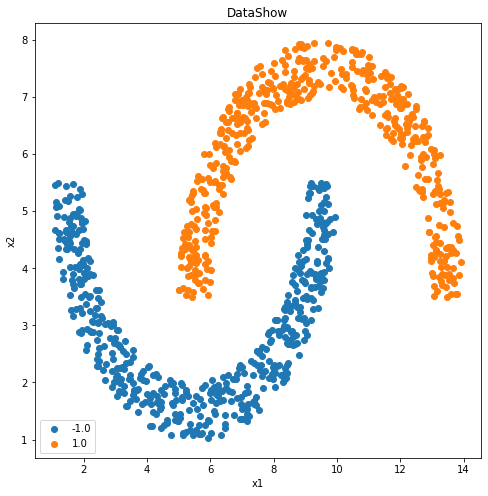

In [4]:
X,y = JY_Toolkit.Jy_makeDataset.draw_HalfMoon(n_sample=1000,slope= 0,ver_distance=-2,positive_val=1,negative_val=-1)
Jy_dataShow.show_TwoDimData(X,y)

In [ ]:
class MLP(object):
    def __init__(self,
                structure : tuple):
        self.num_layers = len(structure)
        self.structure = structure
        self.weights = [np.random.randn(n,m+1) for n,m in zip(structure[1:],structure[:-1])]
        self.activate_func = self.sigmoid
        pass
    # 激活函数
    def sigmoid(self,z):
        ans = 1.0/(1.0 + np.exp(-z))
        return ans
    
    def Relu(self,z):
        return max(0,z)
    # 前向传播
    def single_feed_forwaed(self,X_train):
        # 对单个样本的前向传播
        temp_value = X_train
        # 对每一层的遍历
        for i in range(len(self.weights)):
            # 打印 增广前的输出
            logging.info(f' temp_value : {temp_value}')
            temp_value.append(1.0)
            # 打印 增广后的输出
            logging.info(f'after append, temp_value : {temp_value}')
            temp_value = self.activate_func(np.dot(self.weights[i], temp_value))
        y = temp_value
        return y
        

        
    pass